In [1]:
import os 
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # put -1 to not use any

In [ ]:
import torch
import torch
import SimpleITK as sitk
from PIL import Image
import numpy as np
import pandas as pd
from tqdm import tqdm

from torch.utils.data import Dataset, DataLoader

from torchvision.utils import draw_segmentation_masks
from torchvision.transforms.functional import to_pil_image, pil_to_tensor
import matplotlib.pyplot as plt

from nets.segmentation import  Mask2Former
from loaders.hyst_dataset import BBXImageEvalTransform,BBXImageTrainTransform,BBXImageTestTransform, HystDataModuleFormer
from utils import * 

/home/lumargot/.local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tools/anaconda3/envs/flyby/lib/python3.9/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.3'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [1]:
concats = ['Bipolar', 'Vessel Sealer', 'Robot Grasper Heat', 'Laparoscopic Scissors', 'Laparoscopic Suction', 'Robot Scissors', 'monopolarhook' ]

def construct_class_mapping(df_labels):

    # df_labels = df_labels.loc[df_labels['Video Name'].isin(robo)]

    df_labels.loc[ df_labels['Instrument Name'].isin(concats), 'Instrument Name' ] = 'Others'

    unique_classes = sorted(df_labels['Instrument Name'].unique())
    class_mapping = {value: idx+1 for idx, value in enumerate(unique_classes)}
    return class_mapping

def remove_labels(df, class_mapping, args):
    # concats = ['Bipolar', 'Vessel Sealer', 'Robot Grasper Heat', 'Laparoscopic Scissors', 
    #            'Laparoscopic Suction', 'Robot Scissors', 'monopolarhook' ]
    # concats = ['Bipolar', 'Vessel Sealer', 'Grasper Heat', 'Scissors', 
    #            'Suction', 'monopolarhook' ]
    # df = df.loc[df['Video Name'].isin(robo)]
    df.loc[ df['Instrument Name'].isin(concats), 'Instrument Name' ] = 'Others'

    df[args.class_column] = df['Instrument Name'].map(class_mapping)

    print(f"{df[['Instrument Name', args.class_column]].drop_duplicates()}")
    return df.reset_index()


In [331]:
df_train = pd.read_csv('/CMF/data/lumargot/hysterectomy/mnt/surgery_tracking/csv/dataset_train_train.csv')
df_val = pd.read_csv('/CMF/data/lumargot/hysterectomy/mnt/surgery_tracking/csv/dataset_train_test.csv')
df_test = pd.read_csv('/CMF/data/lumargot/hysterectomy/mnt/surgery_tracking/csv/dataset_test.csv')


df_labels = pd.concat([df_train, df_val, df_test])
class_mapping = construct_class_mapping(df_labels)

df_train = remove_labels(df_train, class_mapping)
df_val = remove_labels(df_val, class_mapping)
df_test = remove_labels(df_test, class_mapping)

print(df_train[['Instrument Name','class']].value_counts())
unique_classes = np.sort(np.unique(df_train['class']))
out_features = len(unique_classes)+1 # background

mnt = '/CMF/data/lumargot/hysterectomy/mnt/surgery_tracking/'
transform = BBXImageTrainTransform()

ttdata = HystDataModuleSeg( df_train, df_val, df_test, batch_size=16, num_workers=4, 
                            img_column='img_path',seg_column='seg_path', class_column='class', 
                            mount_point=mnt,train_transform=BBXImageTrainTransform(),
                            valid_transform=BBXImageEvalTransform(), test_transform=BBXImageTestTransform())

ttdata.setup()
train_dl = ttdata.train_dataloader()

                  Instrument Name  class
0                          Others      4
1                   Robot Grasper      5
2             Robot Needle Driver      6
3            Laparoscopic Grasper      1
1029                       Needle      3
17219  Laparoscopic Needle Driver      2
                 Instrument Name  class
0            Robot Needle Driver      6
1                         Others      4
159                Robot Grasper      5
2885                      Needle      3
2886  Laparoscopic Needle Driver      2
4156        Laparoscopic Grasper      1
                 Instrument Name  class
0                  Robot Grasper      5
1            Robot Needle Driver      6
2                         Others      4
1005        Laparoscopic Grasper      1
1006  Laparoscopic Needle Driver      2
1671                      Needle      3
Instrument Name             class
Robot Needle Driver         6        32065
Robot Grasper               5        27367
Needle                      3    

### Train

In [332]:
for idx, batch in tqdm(enumerate(train_dl)):
  continue

403it [04:38,  1.45it/s]

4


KeyboardInterrupt: 

In [338]:
# Create model
model = Mask2FormerModel(num_classes=out_features, lr=1e-5, batch_size=16)

Some weights of Mask2FormerForUniversalSegmentation were not initialized from the model checkpoint at facebook/mask2former-swin-base-coco-instance and are newly initialized because the shapes did not match:
- class_predictor.bias: found shape torch.Size([81]) in the checkpoint and torch.Size([8]) in the model instantiated
- class_predictor.weight: found shape torch.Size([81, 256]) in the checkpoint and torch.Size([8, 256]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([81]) in the checkpoint and torch.Size([8]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
checkpoint_callback = ModelCheckpoint(dirpath='./', filename='{epoch}-{val_loss:.2f}', save_top_k=2, 
                                      monitor='val_loss', save_last=True,)
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.00, patience=30, verbose=True, mode="min")

trainer = Trainer( max_epochs=100, callbacks=[ checkpoint_callback ], devices=torch.cuda.device_count(), 
                   accelerator="gpu",  log_every_n_steps=5, val_check_interval=0.3,
)

trainer.fit(model, datamodule=ttdata)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Checkpoint directory ./ exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                                | Params
--------------------------------------------------------------
0 | model | Mask2FormerForUniversalSegmentation | 106 M 
--------------------------------------------------------------
106 M     Trainable params
0         Non-trainable params
106 M     Total params
427.542   Total estimated model params size (MB)


Epoch 0:   1%|          | 41/3597 [08:45<12:39:36, 12.82s/it, loss=60.4, v_num=30]

Detected KeyboardInterrupt, attempting graceful shutdown...


: 

## Example

torch.Size([3, 480, 640])


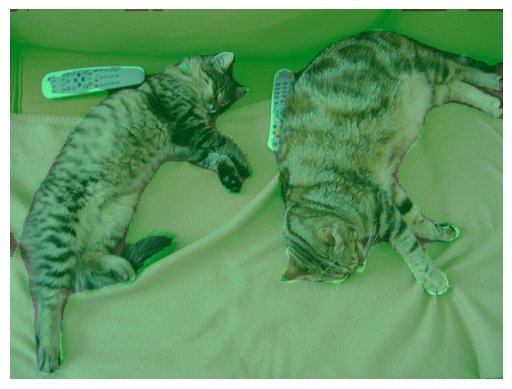

In [ ]:
image_processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-small-coco-instance")
model = Mask2FormerForUniversalSegmentation.from_pretrained(
    "facebook/mask2former-swin-small-coco-instance"
)

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
inputs = image_processor(image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
    
indices = result[0]['segmentation'].unique()
bool_masks = torch.stack([(result[0]['segmentation'] == i) for i in indices], dim=0)
print(bool_masks.shape)

# # Overlay masks
overlay = draw_segmentation_masks(pil_to_tensor(image), masks=bool_masks, alpha=0.5)

# Convert to PIL and plot
pil_image = to_pil_image(overlay)
plt.imshow(pil_image)
plt.axis('off')
plt.show()

## Other

In [ ]:
# Helper function for binary dilation (for adjacency check)
def binary_dilation(array, iterations=1):
    """Simple binary dilation implementation"""
    import numpy as np
    dilated = np.copy(array)
    for _ in range(iterations):
        padded = np.pad(dilated, 1, mode='constant', constant_values=0)
        dilated = np.zeros_like(dilated)
        for i in range(3):
            for j in range(3):
                if i == 1 and j == 1:
                    continue
                dilated |= padded[i:i+dilated.shape[0], j:j+dilated.shape[1]]
    return dilated

# Custom merging function for inference
def merge_overlapping_detections(segmentation, segments_info, iou_threshold=0.5, adjacency_distance=50, score_threshold=0.3):
    """
    Merge detections of the same class that are either overlapping significantly or adjacent.
    
    Args:
        segmentation: Tensor of shape [H, W] with instance segmentation map
        segments_info: List of dictionaries with segment information
        iou_threshold: Minimum IoU to consider segments as overlapping
        adjacency_distance: Maximum pixel distance to consider segments as adjacent
        score_threshold: Minimum score to keep a detection
        
    Returns:
        merged_segmentation: Updated segmentation map
        merged_segments_info: Updated segments information
    """
    import numpy as np
    from collections import defaultdict
    
    # Filter segments by score
    filtered_segments = [seg for seg in segments_info if seg.get("score", 1.0) > score_threshold]
    
    # Group segments by class
    class_to_segments = defaultdict(list)
    for segment in filtered_segments:
        class_to_segments[segment["label_id"]].append(segment)
    
    # Initialize output segmentation map
    merged_segmentation = np.zeros_like(segmentation)
    next_id = 1  # Start with ID 1
    
    # Process each class separately
    merged_segments_info = []
    
    for class_id, segments in class_to_segments.items():
        # If only one segment for this class, no need to merge
        if len(segments) <= 1:
            for segment in segments:
                mask = segmentation == segment["id"]
                merged_segmentation[mask] = next_id
                
                # Update segment info
                new_segment = segment.copy()
                new_segment["id"] = next_id
                merged_segments_info.append(new_segment)
                
                next_id += 1
            continue
        
        # Find segments to merge
        # For each segment, check if it overlaps with or is adjacent to any other segment
        segment_masks = []
        for segment in segments:
            mask = segmentation == segment["id"]
            segment_masks.append(mask)
        
        # Check each pair of segments
        to_merge = []
        for i in range(len(segments)):
            for j in range(i+1, len(segments)):
                # Check if masks overlap
                overlap = np.logical_and(segment_masks[i], segment_masks[j]).sum()
                if overlap > 0:
                    to_merge.append((i, j))
                    continue
                
                # Check if masks are adjacent
                # Dilate first mask and check if it overlaps with second mask
                from scipy.ndimage import binary_dilation
                dilated_mask = binary_dilation(segment_masks[i], iterations=adjacency_distance//2)
                if np.logical_and(dilated_mask, segment_masks[j]).sum() > 0:
                    to_merge.append((i, j))
        
        # Group segments to merge using a union-find algorithm
        parent = list(range(len(segments)))
        
        def find(x):
            if parent[x] != x:
                parent[x] = find(parent[x])
            return parent[x]
        
        def union(x, y):
            parent[find(x)] = find(y)
        
        for i, j in to_merge:
            union(i, j)
        
        # Create groups of segments to merge
        groups = defaultdict(list)
        for i in range(len(segments)):
            groups[find(i)].append(i)
        
        # Merge each group
        for group in groups.values():
            if len(group) == 1:
                # Single segment, no merging needed
                segment = segments[group[0]]
                mask = segment_masks[group[0]]
                merged_segmentation[mask] = next_id
                
                # Update segment info
                new_segment = segment.copy()
                new_segment["id"] = next_id
                merged_segments_info.append(new_segment)
            else:
                # Merge multiple segments
                merged_mask = np.zeros_like(segment_masks[0], dtype=bool)
                for idx in group:
                    merged_mask = np.logical_or(merged_mask, segment_masks[idx])
                
                # Use the segment with highest score as the primary one
                primary_idx = max(group, key=lambda idx: segments[idx].get("score", 0))
                primary_segment = segments[primary_idx].copy()
                
                # Update merged mask in output segmentation
                merged_segmentation[merged_mask] = next_id
                
                # Update segment info
                primary_segment["id"] = next_id
                primary_segment["area"] = int(merged_mask.sum())
                merged_segments_info.append(primary_segment)
            
            next_id += 1
    
    return merged_segmentation, merged_segments_info

# Inference function with custom merging
def inference_with_merging(model, image, processor, device="cuda", iou_threshold=0.5, adjacency_distance=50, score_threshold=0.3):
    """Run inference with Mask2Former and apply custom merging logic"""
    model.to(device)
    model.eval()
    
    # Process image
    inputs = processor(images=image, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # Run inference
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Post-process outputs
    results = processor.post_process_panoptic_segmentation(
        outputs,
        target_sizes=[image.size[::-1]] if hasattr(image, 'size') else [image.shape[:2]],
        label_ids_to_fuse=set(),  # Don't fuse any labels
    )[0]
    
    # Apply custom merging
    merged_segmentation, merged_segments_info = merge_overlapping_detections(
        results["segmentation"],
        results["segments_info"],
        iou_threshold=iou_threshold,
        adjacency_distance=adjacency_distance,
        score_threshold=score_threshold
    )
    
    return {
        "segmentation": merged_segmentation,
        "segments_info": merged_segments_info
    }